<Axes: xlabel='median_house_value', ylabel='Count'>

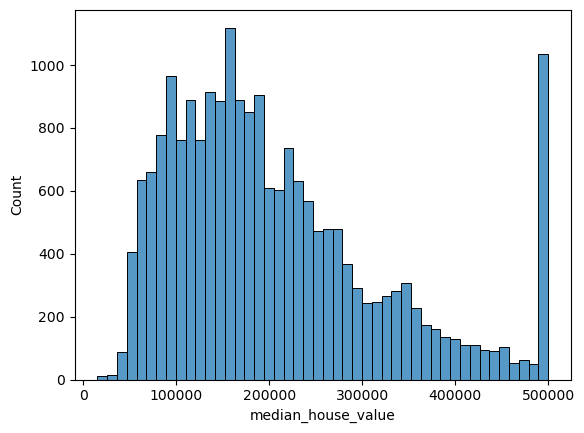

In [120]:
import pandas as pd
import seaborn as sns

%matplotlib inline
df = pd.read_csv('../data/housing.csv')
sns.histplot(df['median_house_value'])


In [121]:
filtered_df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
#select only some columns

filtered_df = filtered_df[
    [
        'latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        'median_income',
        'median_house_value'
    ]
]

filtered_df

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0
...,...,...,...,...,...,...,...,...,...
20635,39.48,-121.09,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,39.49,-121.21,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,39.43,-121.22,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,39.43,-121.32,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


There's one feature with missing values. What is it?

In [122]:
filtered_df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

What's the median (50% percentile) for variable 'population'?

In [123]:
filtered_df['population'].median()

1195.0

In [124]:
import numpy as np
#shuffle the initial dataset
initial_seed = 42
init_size = len(filtered_df)
test_size = int(init_size * 0.2)
val_size = int(init_size * 0.2)
train_size = init_size - test_size - val_size

idx = np.arange(init_size)
np.random.seed(initial_seed)
np.random.shuffle(idx)
train_df = filtered_df.iloc[idx[train_size:]]
val_df = filtered_df.iloc[idx[train_size: train_size + val_size]]
test_df = filtered_df.iloc[idx[train_size + val_size:]]
# recreate the index after shuffling
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

(len(train_df), len(val_df), len(test_df))



(6274, 3137, 3137)

In [125]:
y_train = np.log1p(train_df['median_house_value'].values)
y_val = np.log1p(val_df['median_house_value'].values)
y_test = np.log1p(test_df['median_house_value'].values)

# remove the target from the dataset so we can train and validate
del train_df['median_house_value']
del val_df['median_house_value']
del test_df['median_house_value']

## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?

In [126]:
train_df_filled_mean = train_df.copy()
train_df_filled_mean['total_bedrooms'].fillna(train_df['total_bedrooms'].mean(), inplace=True)
train_df_with_zeros = train_df.copy()
train_df_with_zeros['total_bedrooms'].fillna(0, inplace=True)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

0.33

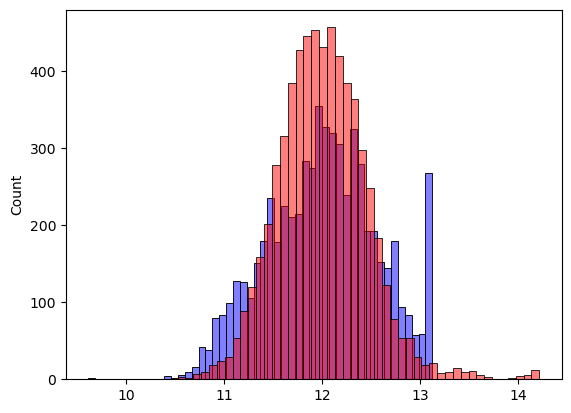

In [127]:
w0, w = train_linear_regression(train_df_filled_mean, y_train)
y_pred_with_mean = w0 + train_df_filled_mean.values.dot(w)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
sns.histplot(y_pred_with_mean, color='red', alpha=0.5, bins=50)
score = rmse(y_train, y_pred_with_mean)
round(score, 2)


0.34

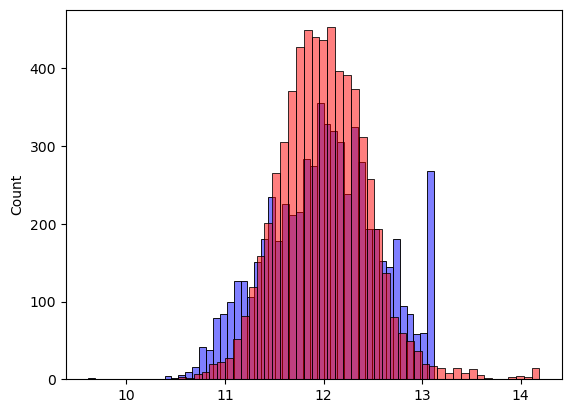

In [128]:
w0, w = train_linear_regression(train_df_with_zeros, y_train)
y_pred_with_zeros = w0 + train_df_with_zeros.values.dot(w)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
sns.histplot(y_pred_with_zeros, color='red', alpha=0.5, bins=50)
score = rmse(y_train, y_pred_with_zeros)
round(score, 2)

In [129]:
def prepare_X(X):
    X['total_bedrooms'].fillna(0, inplace=True)
    return X

def split_and_shuffle(X,seed):
    init_size = len(filtered_df)
    test_size = int(init_size * 0.2)
    val_size = int(init_size * 0.2)
    train_size = init_size - test_size - val_size

    idx = np.arange(init_size)
    np.random.seed(seed)
    np.random.shuffle(idx)
    train_df = filtered_df.iloc[idx[train_size:]]
    val_df = filtered_df.iloc[idx[train_size: train_size + val_size]]
    test_df = filtered_df.iloc[idx[train_size + val_size:]]
    # recreate the index after shuffling
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    y_train = np.log1p(train_df['median_house_value'].values)
    y_val = np.log1p(val_df['median_house_value'].values)
    y_test = np.log1p(test_df['median_house_value'].values)

    # remove the target from the dataset so we can train and validate
    del train_df['median_house_value']
    del val_df['median_house_value']
    del test_df['median_house_value']
    return train_df, val_df, test_df, y_train, y_val, y_test

## Question 4

Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?

In [130]:
# train_df_with_zeros 
# print(train_df_with_zeros.head())
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]
seed = 42
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X = filtered_df.copy()
    X_train, X_val, X_test, y_train, y_val, y_test = split_and_shuffle(X,seed)
    X_train = prepare_X(X_train)
    w0, w = train_linear_regression_reg(X_train,y_train,r)
    X_val = prepare_X(X_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_test, y_pred)
    print("R value %s has RMSE of %s"% (r, round(score, 2)))



R value 0 has RMSE of 0.73
R value 1e-06 has RMSE of 0.73
R value 0.0001 has RMSE of 0.73
R value 0.001 has RMSE of 0.73
R value 0.01 has RMSE of 0.73
R value 0.1 has RMSE of 0.72
R value 1 has RMSE of 0.72
R value 5 has RMSE of 0.71
R value 10 has RMSE of 0.71


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

In [131]:



scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X = filtered_df.copy()
    X_train, X_val, X_test, y_train, y_val, y_test = split_and_shuffle(X,seed)
    X_train = prepare_X(X_train)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_train.dot(w)
    score = rmse(y_train,y_pred)
    scores.append(score)
    
round(np.array(scores).std(),3)

0.004

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- 0.33
- 0.43

In [132]:
X = filtered_df.copy()
seed = 9
X_train, X_val, X_test, y_train, y_val, y_test = split_and_shuffle(X,seed)
X_train = pd.concat([X_train,X_val])
X_train.reset_index(drop=True)
y_train = np.concatenate([y_train,y_val])
X_train = prepare_X(X_train)
w0, w = train_linear_regression_reg(X_train, y_train, 0.001)
X_test = prepare_X(X_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test,y_pred)
score

0.3342875794249169